# Mouse gastrulation and early organogenesis Dataset: Blood Trajectory

## Table of Contents:
* ### [Data Pre-Processing](#1-bullet)
 * #### [Data Before Processing](#2-bullet)
 * #### [Data Normalization](#3-bullet)
 * #### [Highly-Variable Gene Selection](#4-bullet)
 
* ### [Data Visualization and Clustering](#5-bullet)
 * #### [Principal Component Analysis](#6-bullet)
 * #### [Computing the Neighborhood Graph and UMAPs](#7-bullet)
 * #### [Clustering](#8-bullet)
 * #### [Force Atlas Dimensionality Reduction](#9-bullet)
 
* ### [Pseudotime Trajectory Analysis [Slingshot R]](#12-bullet)
* ### [Conclusion](#15-bullet)

Below, we replicate the scRNA-seq analysis and do pathway state analysis on the blood trajectory from the E6.5-E8.5 day mouse developmental scRNA-seq atlas published by [Pijuan-Sala et al. (2019)](https://www.nature.com/articles/s41586-019-0933-9#Abs1) in their paper __"A single-cell molecular map of mouse gastrulation and early organogenesis."__ 

In [1]:
import warnings # ignores annoying warnings that pop up during import of packags
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb
from gprofiler import GProfiler

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.font_manager
matplotlib.rcParams['font.family'] = "Arial"
from matplotlib.figure import Figure
from matplotlib.backend_bases import FigureCanvasBase
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

import module as md

import panel as pn
pn.extension()

from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.rinterface_lib.callbacks

import glob

from scipy.stats import mode

In [2]:
# We're going to change some of the parameters for warning/error messages in several packages. 
import logging

# This ignores an annoying matplotlib error that comes up with the colors on a plot.
matplotlib_axes_logger.setLevel('ERROR')

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set on Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()   # print package settings for Scanpy (replicability)
sc.settings.set_figure_params(dpi=80)

# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
figdir = '../figures/'
datadir = '../../data/raw_data/sc_data/early_organogenesis/'
resdir = '../../data/processed_data/sc_data/early_organogenesis/'

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.7.0


In [3]:
%%R
library(slingshot)

## Data Pre-Processing <a class="anchor" id="1-bullet"></a>

Pijuan-Sala upload the raw data and metadata annotations on Array Express https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6967/

In [4]:
adata = sc.read(datadir+"matrix.mtx",cache=True).T

adata.obs.index = pd.read_csv(datadir+"barcodes.tsv", delimiter="\t")["barcode"]
adata.var.index = pd.read_csv(datadir+"genes.tsv", delimiter="\t")["gene"]

adata

... reading from cache file cache/..-..-data-raw_data-sc_data-early_organogenesis-matrix.h5ad


AnnData object with n_obs × n_vars = 139331 × 29452

In [5]:
meta = pd.read_csv(datadir+"meta.csv")
meta = meta.set_index(meta["barcode"])
meta = meta.drop("barcode", axis=1)

adata.obs["stage"] = meta["stage"]
adata.obs["batch"] = meta["sequencing.batch"]
adata.obs["batch"] = [str(i) for i in adata.obs["batch"]]
adata.obs["cell_type"] = meta["celltype"]

adata.obs_names_make_unique()
adata.var_names_make_unique()
adata = adata[~adata.obs["cell_type"].isna()]

meta.head()

cell  sample stage  sequencing.batch theiler  doub.density  \
barcode                                                                        
AAAGGCCTCCACAA  cell_1       1  E6.5                 1     TS9      0.043114   
AACAAACTCGCCTT  cell_2       1  E6.5                 1     TS9      1.129713   
AACAATACCCGTAA  cell_3       1  E6.5                 1     TS9      0.000000   
AACACTCTCATTCT  cell_4       1  E6.5                 1     TS9      0.084689   
AACAGAGAATCAGC  cell_5       1  E6.5                 1     TS9      0.112121   

                doublet  cluster  cluster.sub  cluster.stage  ...  \
barcode                                                       ...   
AAAGGCCTCCACAA    False      2.0          4.0            2.0  ...   
AACAAACTCGCCTT    False     12.0          1.0            1.0  ...   
AACAATACCCGTAA    False      NaN          NaN            NaN  ...   
AACACTCTCATTCT    False      NaN          NaN            NaN  ...   
AACAGAGAATCAGC    False      3.0          7.0            4.0  ...   

                haem_gephiY  haem_subclust endo_gephiX endo_gephiY  \
barcode                                                              
AAAGGCCTCCACAA          NaN            NaN         NaN         NaN   
AACAAACTCGCCTT          NaN            NaN         NaN         NaN   
AACAATACCCGTAA          NaN            NaN         NaN         NaN   
AACACTCTCATTCT          NaN            NaN         NaN         NaN   
AACAGAGAATCAGC          NaN            NaN         NaN         NaN   

                endo_trajectoryName  endo_trajectoryDPT  endo_gutX  endo_gutY  \
barcode                                                                         
AAAGGCCTCCACAA                  NaN                 NaN        NaN        NaN   
AACAAACTCGCCTT                  NaN                 NaN        NaN        NaN   
AACAATACCCGTAA                  NaN                 NaN        NaN        NaN   
AACACTCTCATTCT                  NaN                 NaN        NaN        NaN   
AACAGAGAATCAGC                  NaN                 NaN        NaN        NaN   

               endo_gutDPT  endo_gutCluster  
barcode                                      
AAAGGCCTCCACAA         NaN              NaN  
AACAAACTCGCCTT         NaN              NaN  
AACAATACCCGTAA         NaN              NaN  
AACACTCTCATTCT         NaN              NaN  
AACAGAGAATCAGC         NaN              NaN  

[5 rows x 27 columns]

### Data Before Processing <a class="anchor" id="2-bullet"></a>

Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:05)


... storing 'stage' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical


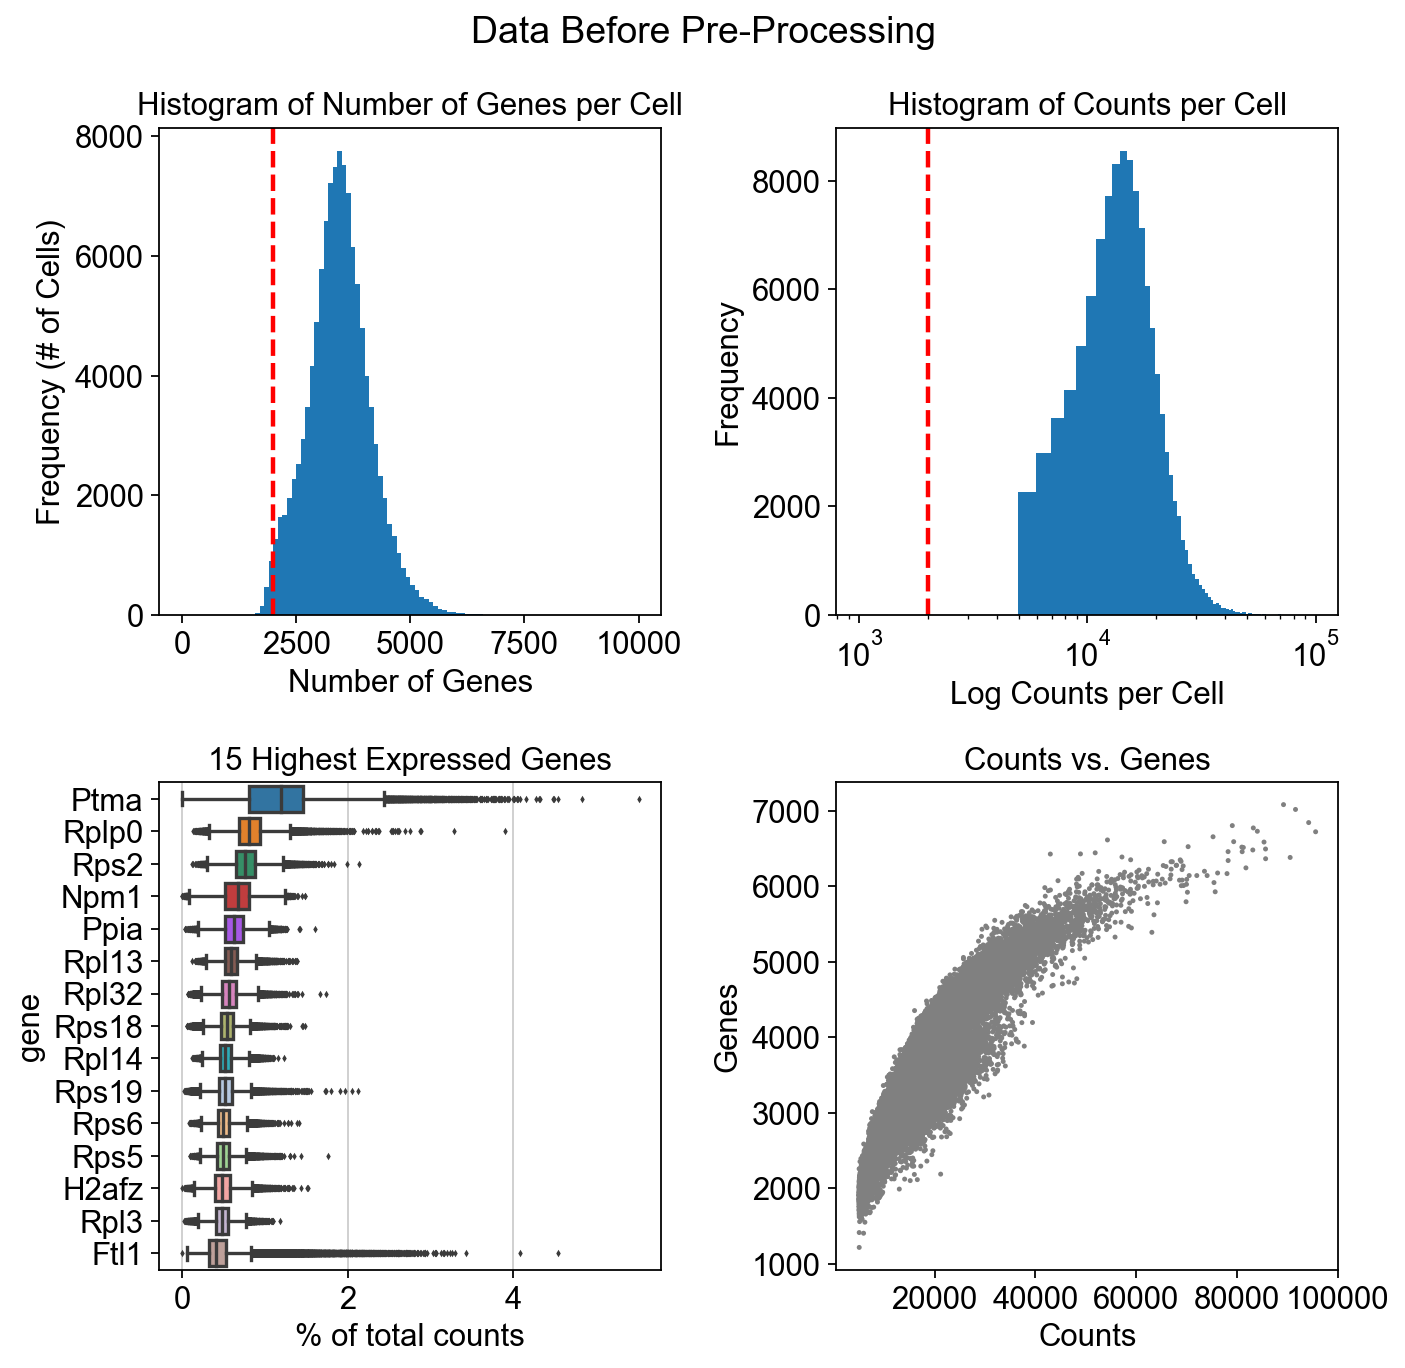

CPU times: user 35.8 s, sys: 45.3 s, total: 1min 21s
Wall time: 1min 37s


In [6]:
%%time

# Below, we display cells with genes/cell and counts/cell, for genes that 
# have at least one 1 count in any cell. 
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Set annotations to the AnnData object for total counts, cells per gene, and mitochondrial genes
adata.obs['n_total_counts_per_cell'] = (adata.X.sum(axis=1).A1)
adata.var['n_cells_per_gene'] = adata.X.astype(bool).astype(int).sum(axis=0).A1
adata.obs['n_genes_per_cell'] = adata.X.astype(bool).astype(int).sum(axis=1).A1

# This line of code makes a plot with the different plots on the data
# prior to processing it. 
pre_processed = md.vis_pre_processing(adata, genes_range=(0, 10000),
    counts_range=(1e3, 1e5),title='Data Before Pre-Processing',
                                     genes_threshold = 2000, counts_threshold=2000)

We can isolate the blood trajectory cells from the early organogenesis atlas
- Haematoendothelial progenitors
- Endothelium
- Mixed mesoderm
- Erythroid cell types
- Blood progenitors

In [7]:
blood_adata = adata[adata.obs["cell_type"].isin(["Haematoendothelial progenitors",
                                                "Blood progenitors 1", 
                                                "Blood progenitors 2", 
                                                "Endothelium", "Erythroid1",
                                                "Erythroid2", "Erythroid3",
                                                "Mixed mesoderm"])]
blood_adata

View of AnnData object with n_obs × n_vars = 15875 × 29452
    obs: 'stage', 'batch', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell'
    var: 'n_cells', 'n_cells_per_gene'

Trying to set attribute `.var` of view, copying.


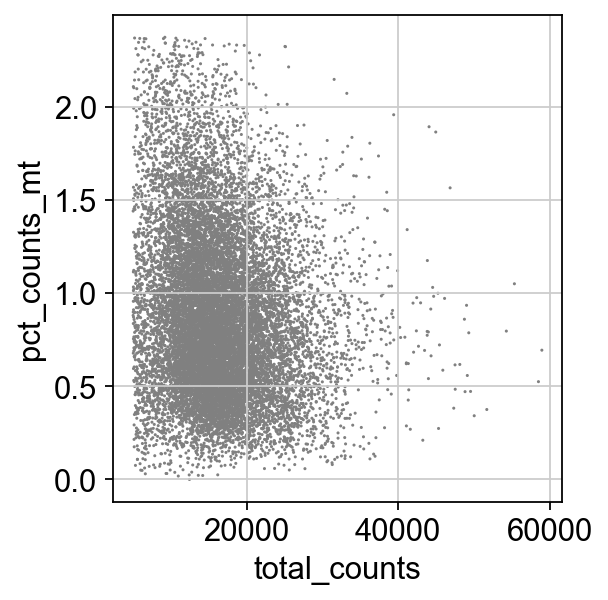

In [8]:
blood_adata.var['mt'] = blood_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(blood_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(blood_adata, x='total_counts', y='pct_counts_mt')

The authors of the paper use a minimum gene filter of 1,000 genes/cell. We will also use this filter. They have no counts filter (the gene quality control filters out cells with low counts, so a count filter is unnecessary). The authors also use a filter of 8,000 maximum genes/cell and cells with a percent mitochondrial count below 20%. The gene matrix as published already has the cells filtered in accordance with the above standards, so the number of cells does not change.

The authors also apply a filter on genes such that only genes expressed in at least 0.001% of cells (~90 cells) are kept. We apply this filter on genes.

filtered out 230 cells that have less than 2000 genes expressed
filtered out 14167 genes that are detected in less than 15 cells


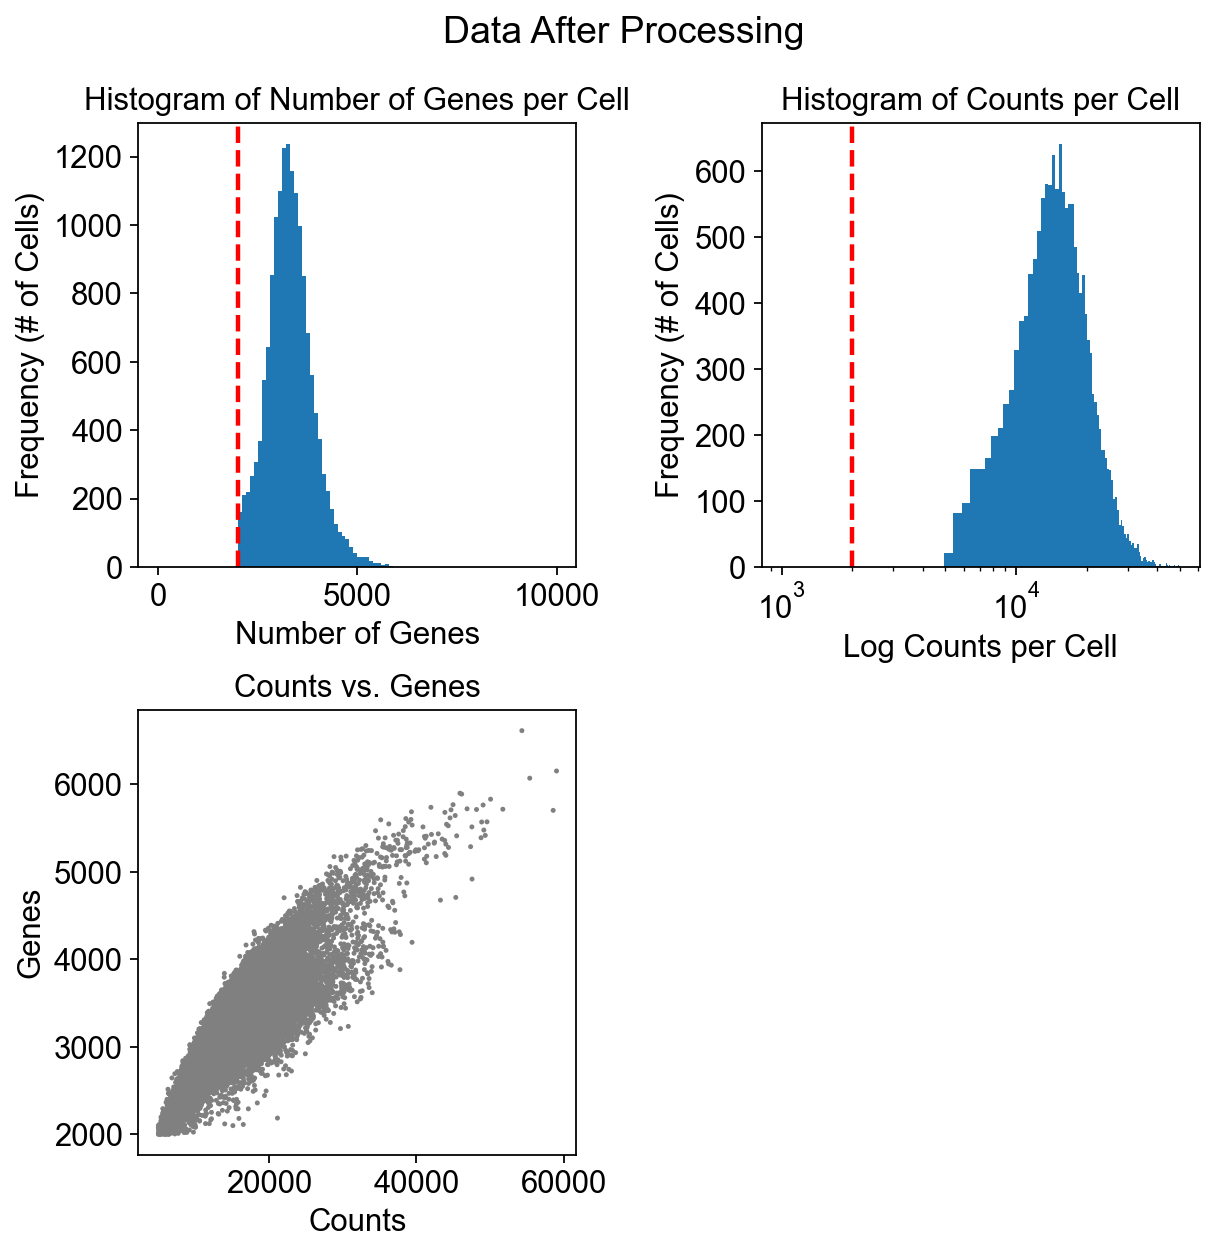

CPU times: user 4.16 s, sys: 938 ms, total: 5.1 s
Wall time: 3.15 s


In [9]:
%%time

blood_adata = md.filter_data(blood_adata, min_counts=2000, min_genes=2000, min_cells=int(blood_adata.shape[0]*0.001))

post_processing = md.vis_post_processing(blood_adata, genes_range=(0, 10000),
    counts_range=(1e3, 5e4),title='Data After Processing',
                                     genes_threshold = 2000, counts_threshold=2000)

### Data Normalization <a class="anchor" id="3-bullet"></a>

In [10]:
%%time
# We save a copy of the AnnData object prior to normalization for differential expression testing.

pre_norm = blood_adata.copy()

# Normalize the data
sc.pp.normalize_total(blood_adata, target_sum=1e6)
sc.pp.log1p(blood_adata)

# We set the raw attribute of our AnnData object as the normalized count matrix. 
blood_adata.raw = blood_adata

sc.pp.normalize_total(pre_norm, target_sum=1e4)
sc.pp.log1p(pre_norm)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
CPU times: user 1.66 s, sys: 267 ms, total: 1.92 s
Wall time: 1.93 s


### Highly-Variable Gene Selection <a class="anchor" id="4-bullet"></a>

We select the top 4,000 highly variable genes. He et. al do something slightly different, by detecting the genes with higest disperson.

Subsequently, we filter out all genes except our highly variable genes, thus only keeping genes that are informative of the heterogeneity of our data. This "dense" matrix is necessary for downstream operations because a larger matrix is more computationally expensive.

In [11]:
%%time

sc.pp.highly_variable_genes(blood_adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = 2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 602 ms, sys: 105 ms, total: 707 ms
Wall time: 712 ms


Below, we select for genes of interest: Bmp, Wnt, Notch, Eph, Fgfr, Splice SRSF, and LPA pathway genes, and marker genes specified in the paper. Note that these genes we select pass our quality-control filters above. Since these genes may not necessarily be highly-variable, we "force" our gene expression matrix to keep our genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell and percentage of counts that are from mitochondrial genes. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [12]:
%%time

# get_genes returns a list of genes that are actually in the filtered data matrix (genes that pass the QC filters)
wnt_ligands = md.get_genes(blood_adata, md.wnts)
wnt_receptors = md.get_genes(blood_adata, md.wntr)
bmp_ligands = md.get_genes(blood_adata, md.bmps)
bmp_receptors = md.get_genes(blood_adata, md.bmpr)
notch = md.get_genes(blood_adata, md.notch)
eph_receptors = md.get_genes(blood_adata, md.ephr)
eph_ligands = md.get_genes(blood_adata, md.ephl)
fgfr = md.get_genes(blood_adata, md.fgfr)
splice_srsf = md.get_genes(blood_adata, md.splice_srsf)
lpa = md.get_genes(blood_adata, md.lpa)


# Get this from the paper!
high_exp = ["Gapdh", "Malat1"]
markers = ["Isl1", "Gfpt2", "Tnnt1", "Has2", "Nkx2-3", "Nkx2-5",
          "Kctd12b", "Foxe1", "Bambi", "Cdkn1c", "Phlda2", "Hhex", "Ttr", "Sfrp5",
          "Upp1", "Fzd7", "Osr1", "Ripply3", "Hoxa1", "Irx2", "Fzd2", "Irx1", "Nepn",
          "Nudt11", "Pdzk1ip1", "Hacd4", "Prss8", "B4galt6", "Kitl", "Sct", 
          "Hoxa10", "Cxcl12", "2610528A11Rik", "Tfpi", "Trf", "Xlr3a", "Trap1a",
          "Rhox5", "Cited1", "Cdx1", "Hoxb2", "Zfp503", "Stra6", "Mnx1", "Tlx2",
          "Hoxc9", "Axin2", "Wnt5b", "Smim3", "Cdx2"]

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch, 'Eph Receptors': eph_receptors, 
           'Eph ligands': eph_ligands, 'Fgfr': fgfr, 'Splice SRSF': splice_srsf,
           'LPA': lpa}

all_genes = wnt_ligands + wnt_receptors + bmp_ligands + bmp_receptors + notch + high_exp + markers + eph_receptors + eph_ligands + fgfr + splice_srsf + lpa

blood_adata=md.merge_genes(blood_adata, all_genes)
sc.pp.regress_out(blood_adata, ['n_total_counts_per_cell'])
sc.pp.regress_out(blood_adata, ['pct_counts_mt'])
sc.pp.scale(blood_adata)

regressing out ['n_total_counts_per_cell']
    sparse input is densified and may lead to high memory use
    finished (0:03:23)
regressing out ['pct_counts_mt']
    finished (0:02:23)
CPU times: user 43min 4s, sys: 1min 15s, total: 44min 19s
Wall time: 5min 53s


In [13]:
blood_adata

AnnData object with n_obs × n_vars = 15645 × 15125
    obs: 'stage', 'batch', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

## Data Visualization <a class="anchor" id="5-bullet"></a>

### Principal component analysis <a class="anchor" id="6-bullet"></a>

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


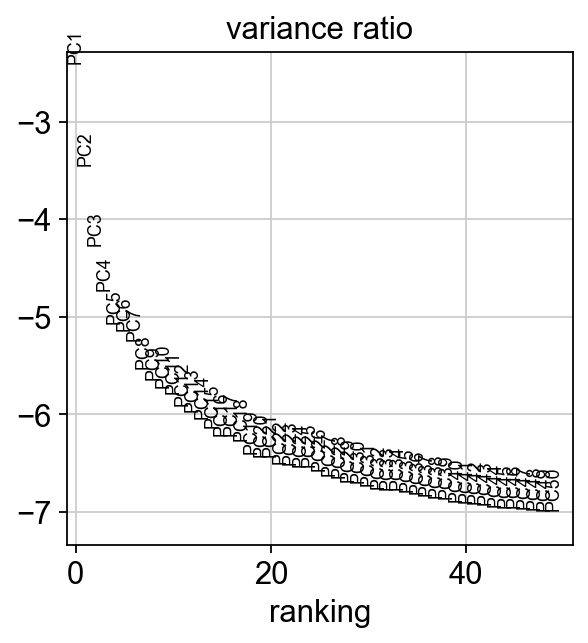

In [14]:
sc.tl.pca(blood_adata, svd_solver='arpack', n_comps=50)

sc.pl.pca_variance_ratio(blood_adata, log=True, n_pcs=50)

### Computing the Neighborhood Graph and UMAPs <a class="anchor" id="7-bullet"></a>

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [15]:
sc.pp.neighbors(blood_adata, n_neighbors=28, n_pcs=15) #28, 15

sc.tl.umap(blood_adata, n_components=2)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


### Clustering <a class="anchor" id="8-bullet"></a>

We then want to group the cells based on similarity of gene expression. These smaller clusters can inform us of the heterogeneity within the cell types they make up.

In [16]:
sc.tl.leiden(blood_adata, resolution = 0.6)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


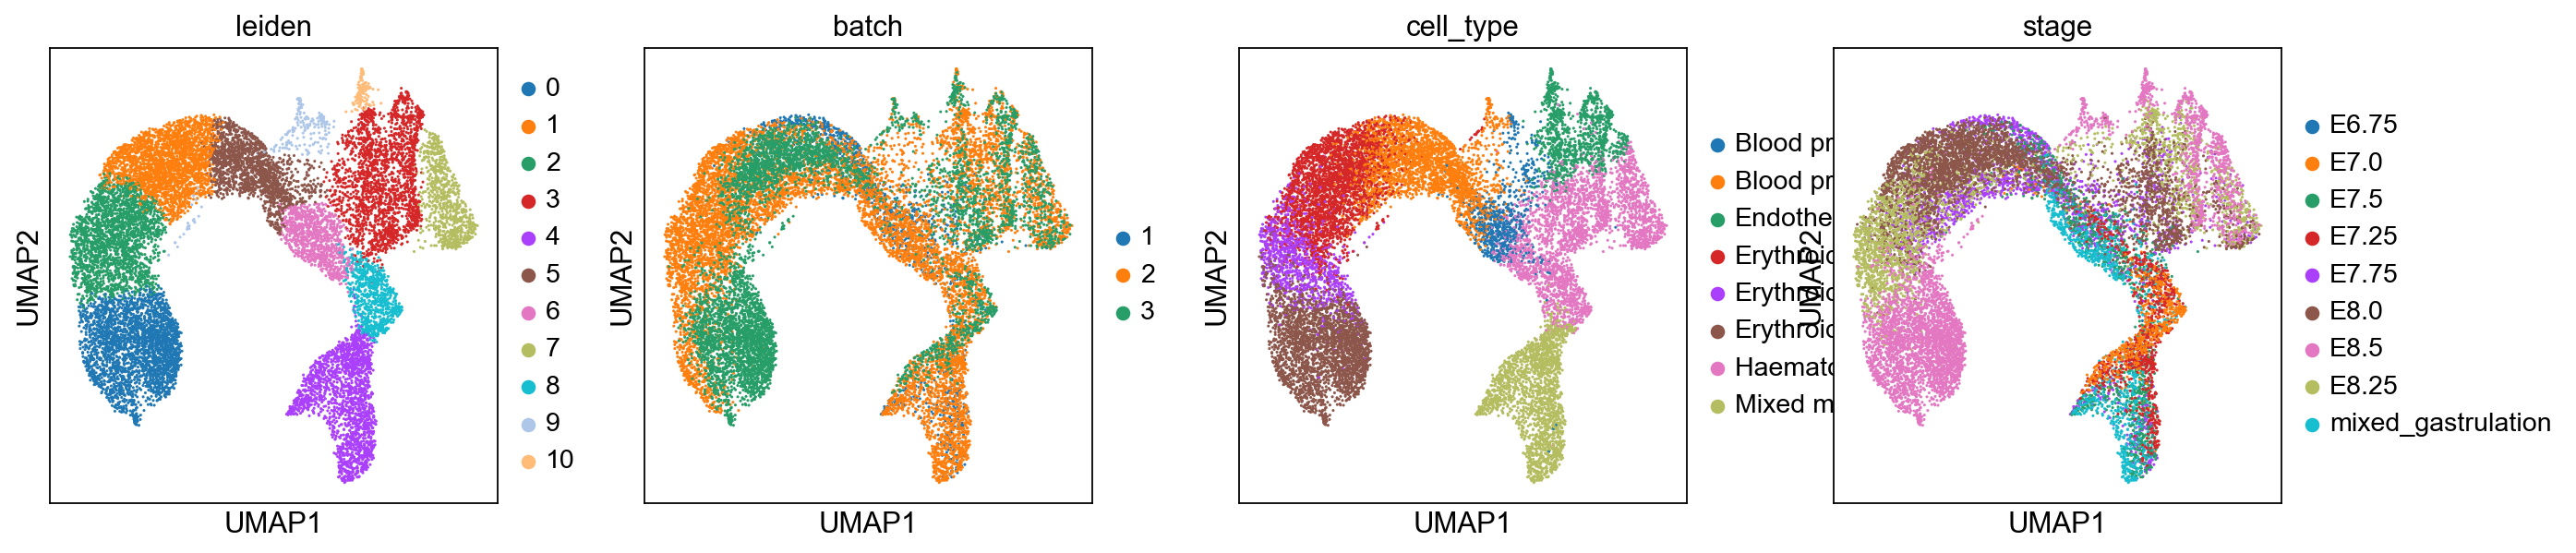

In [17]:
sc.pl.umap(blood_adata, color = ["leiden", "batch", "cell_type", "stage"])

#### Force Atlas Dimensionality Reduction <a class="anchor" id="9-bullet"></a>

In [18]:
sc.tl.draw_graph(blood_adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:33)


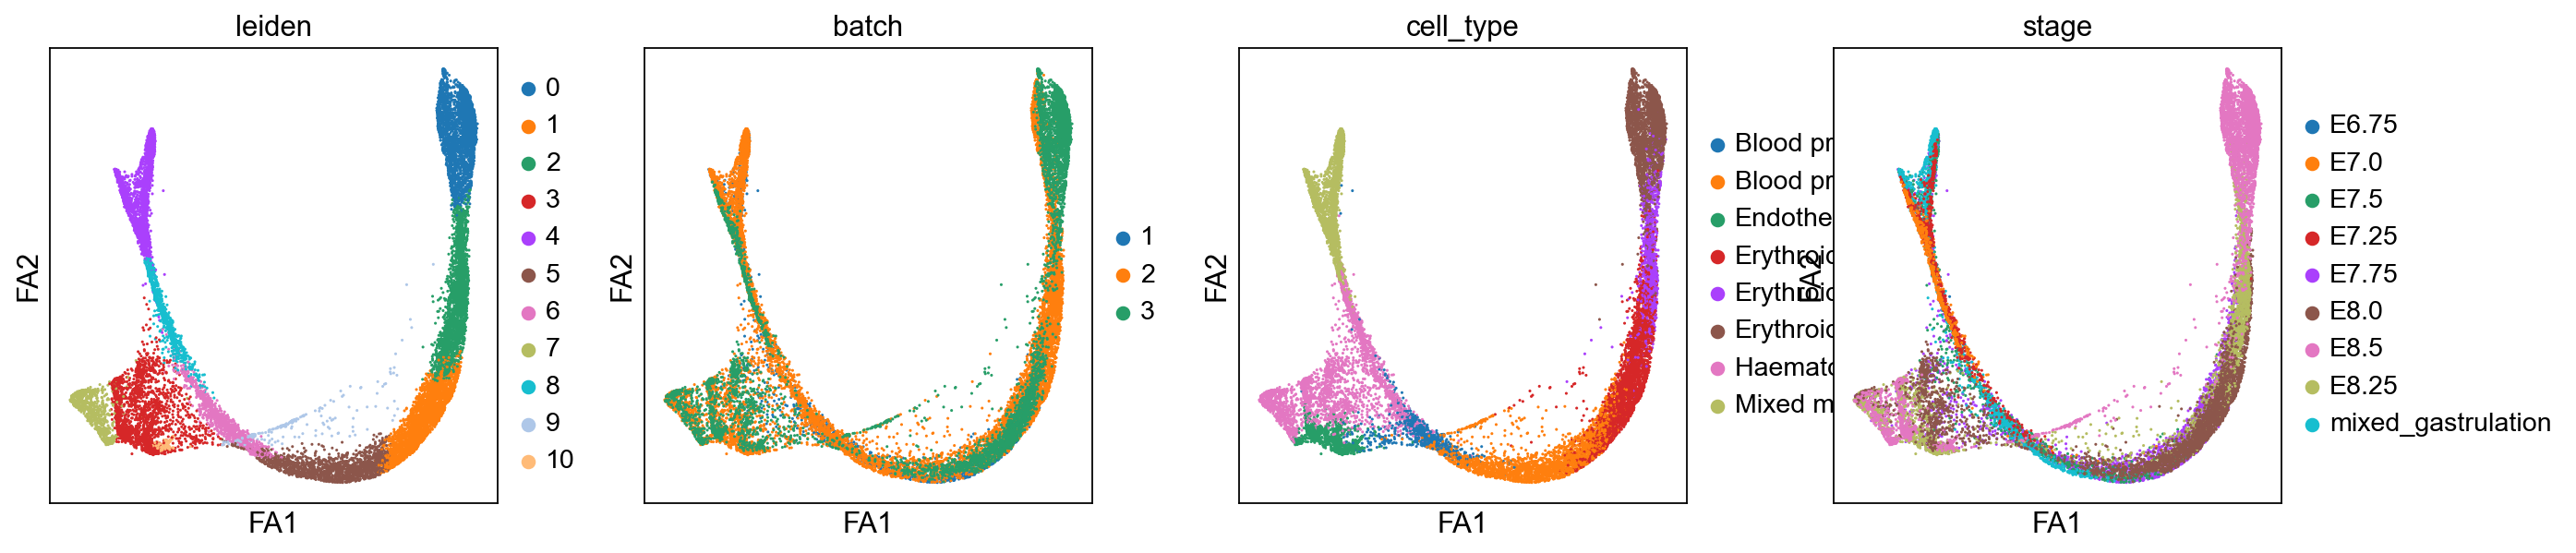

In [19]:
sc.pl.draw_graph(blood_adata, color = ["leiden", "batch", "cell_type", "stage"])

In [20]:
blood_adata = blood_adata[~blood_adata.obs['leiden'].isin(["9", "10"])]

blood_adata

View of AnnData object with n_obs × n_vars = 15304 × 15125
    obs: 'stage', 'batch', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors', 'cell_type_colors', 'stage_colors', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Pseudotime Trajectory Analysis [Slingshot R] <a class="anchor" id="12-bullet"></a>

Our dimensionality reduction of the blodo cell trajectory seems to match that from the publication. We can now do pseudotime analysis on this with Slingshot, a pseudotime analysis package in R. We can pass our AnnData object into R with anndata2ri (which relies on rpy2), which makes the AnnData object a SingleCellExperiment (SCE) object in an R environment.

In [21]:
# anndata2ri for some reason cannot pass the neighbors attribute into the SCE object so 
# we need to delete this attribute.

blood_sce = blood_adata.copy() # make a copy of blood_adata AnnData object

del blood_sce.uns['neighbors'] # delete the neighbors attribute of the blood_adata AnnData object.

We can do pseudotime analysis on our skin cells with Slingshot. 

Pijuan-Sala et al. uses as a root the cluster with the most cells at the earliest stage of the blood trajectory (Mixed mesoderm), with two lineages—the endothelium and the erythroid trajectories. We can match our leiden clusters on our FA projection to define these root and endpoint clusters. We will do the pseudotime analysis with the R program Slingshot. 

We send our AnnData object to R, so it is transformed to a SCE object, and do Slingshot pseudotime trajectory analysis on it.

In [22]:
%%time
%%R -i blood_sce

print("1:")

blood_sling <- slingshot(blood_sce, 
                           clusterLabels = 'leiden', 
                           reducedDim = 'X_draw_graph_fa',start.clus = c("4"), end.clus = c("0", "7"),
                        approx_points=200) # these clusters are the endpoints

print(SlingshotDataSet(blood_sling))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
   15304          2

lineages: 2 
Lineage1: 4  8  6  5  1  2  0  
Lineage2: 4  8  6  3  7  

curves: 2 
Curve1: Length: 150760	Samples: 12472.69
Curve2: Length: 66929	Samples: 5260.07
CPU times: user 2min 1s, sys: 12.5 s, total: 2min 14s
Wall time: 2min 20s


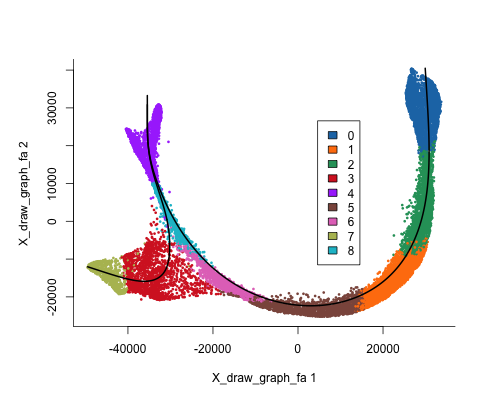

In [23]:
%%R -w 500 -h 400 # we can plot the lineages below.

par(xpd=TRUE)
par(mar=c(5, 5, 4, 3) + 0.1)
plot(reducedDims(blood_sce)$X_draw_graph_fa[,1], 
     reducedDims(blood_sce)$X_draw_graph_fa[,2], 
     col=unlist(metadata(blood_sce)$leiden_colors)[colData(blood_sce)$leiden], 
     bty='L', xlab='X_draw_graph_fa 1', ylab='X_draw_graph_fa 2', pch=16, cex=0.5)
lines(SlingshotDataSet(blood_sling), lwd=2)

legend("right", inset=c(0.25,0.1), legend=sort(unique(colData(blood_sce)$leiden)), 
       fill=unlist(metadata(blood_sce)$leiden_colors))

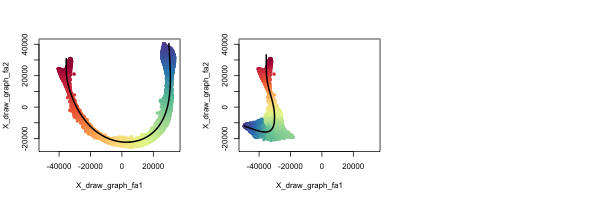

In [24]:
%%R -w 600 -h 200

library(RColorBrewer)
par(mfrow=c(1,3))

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(blood_sling)$X_draw_graph_fa[,c(1,2)], col = colors[cut(blood_sling$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='X_draw_graph_fa1', ylab='X_draw_graph_fa2')
lines(slingCurves(blood_sling)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(blood_sling)$X_draw_graph_fa[,c(1,2)], col = colors[cut(blood_sling$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='X_draw_graph_fa1', ylab='X_draw_graph_fa2')
lines(slingCurves(blood_sling)$curve2, lwd=2)

We can see that there are 2 lineages, and they correspond to the lineages published. 
To save the pseudotime values and trajectory coordinates, we can send dataframes of these values out to Python, and save them to our AnnData objects.

In [25]:
%%R -o pt_df,traj1,traj2

# We could just pass our nephron_sling object as output from our R cell and make it a
# sce object with anndata2ri, but it's nice to have all our annotations on one object.

# We can save the pseudotime values
pt_df <- as.data.frame(slingPseudotime(blood_sling, na=False))

# We can save the curve coordinates of the trajectories (for easy plotting with scanpy!)
traj <- slingCurves(blood_sling)
traj1 <- traj$curve1$s
traj2 <- traj$curve2$s

In [26]:
# Add the pseudotime values as obs annotations to our scanpy object
blood_adata.obs['slingPseudotime_1'] = pt_df['curve1']
blood_adata.obs['slingPseudotime_2'] = pt_df['curve2']

# Add the curve coordinates to the scanpy object.
blood_adata.uns['curve1'] = traj1
blood_adata.uns['curve2'] = traj2

Trying to set attribute `.obs` of view, copying.


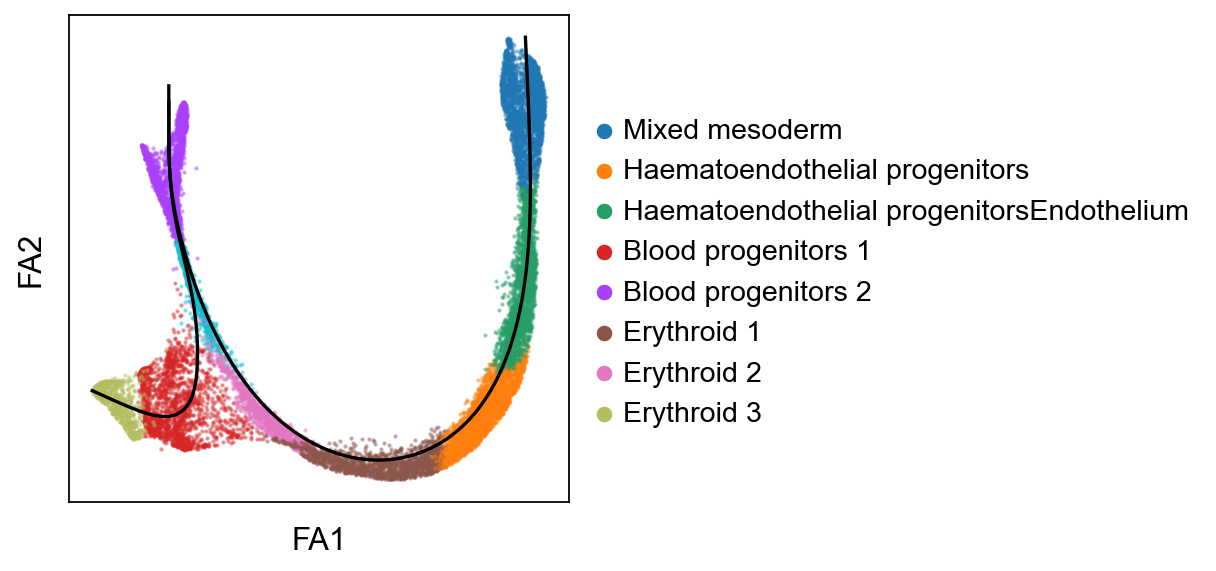

In [27]:
fig, ax = plt.subplots()

for idx, i in enumerate(["4", "8", "6", "5", "1", "2", "0", "3", "7"]):
    subset = blood_adata[blood_adata.obs["leiden"] == i]
    col_idx = list(blood_adata.obs["leiden"].cat.categories).index(i)
    ax.scatter([],[],
               label=i)
handles, labels = ax.get_legend_handles_labels()


for idx, i in enumerate(["4", "8", "6", "5", "1", "2", "0", "3", "7"]):
    subset = blood_adata[blood_adata.obs["leiden"] == i]
    col_idx = list(blood_adata.obs["leiden"].cat.categories).index(i)
    ax.scatter(subset.obsm["X_draw_graph_fa"][:,0],
               subset.obsm["X_draw_graph_fa"][:,1],
               c = blood_adata.uns["leiden_colors"][col_idx],s=1,
               label=i, alpha=0.4)

ax.legend(handles, labels=["Mixed mesoderm", "Haematoendothelial progenitors", "Haematoendothelial progenitors"
                           "Endothelium", "Blood progenitors 1", "Blood progenitors 2",
                           "Erythroid 1", "Erythroid 2", "Erythroid 3"], 
          loc='lower center', bbox_to_anchor=(1.65,0.1), frameon=False, ncol=1)

ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("FA1")
ax.set_ylabel("FA2")
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    
ax.plot(blood_adata.uns['curve1'][:,0], blood_adata.uns['curve1'][:,1],color='black')
ax.plot(blood_adata.uns['curve2'][:,0], blood_adata.uns['curve2'][:,1],color='black');

plt.savefig(figdir+"Figure_7C.pdf", bbox_inches="tight")

## Conclusion <a class="anchor" id="15-bullet"></a>

We can save all our raw data for downstream analysis of our profiles against those from the integrated atlas.

In [28]:
# This dataframe has the counts normalized to 1e4 as we want
pre_norm = pre_norm[blood_adata.obs.index].copy()

# Get the Leiden cluster labels for each AnnData object
clusters = list(blood_adata.obs['leiden'].unique())

# Initialize a DataFrame
df = pd.DataFrame(index = clusters, columns = blood_adata.raw.var.index)

# Compute the average expression of all genes for each Leiden cluster
for cluster in clusters:
    df.loc[cluster] = pre_norm[blood_adata.obs['leiden'] == cluster].X.mean(0)

# Add metadata for each Leiden cluster (stage, cell type, tissue, and the # of cells in each cluster)
df["stage"] = [blood_adata[blood_adata.obs["leiden"]==i].obs["stage"].value_counts().idxmax() for i in df.index]
df["cell_type"] = [blood_adata[blood_adata.obs["leiden"]==i].obs["cell_type"].value_counts().idxmax() for i in df.index]
df["num_cells"] = [blood_adata[blood_adata.obs["leiden"]==i].shape[0] for i in df.index]

# Save the DataFrame
df.to_csv(resdir + "blood_allgenes.csv")

In [29]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,panel,anndata,scanpy,anndata2ri,rpy2,jupyterlab

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.17.0

numpy     : 1.18.5
pandas    : 1.1.0
scipy     : 1.5.2
seaborn   : 0.10.1
matplotlib: 3.2.2
panel     : 0.9.7
anndata   : 0.7.4
scanpy    : 1.5.1
anndata2ri: 0.0.0
rpy2      : 3.3.2
jupyterlab: 2.2.4



In [30]:
%%R
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/libopenblasp-r0.3.10.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          SingleCellExperiment_1.8.0 
 [3] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [5] BiocParallel_1.20.1         matrixStats_0.56.0         
 [7] Biobase_2.46.0              GenomicRanges_1.38.0       
 [9] GenomeInfoDb_1.22.1         IRanges_2.20.2             
[11] S4Vectors_0.24.4            BiocGenerics_0.32.0        
[13] slingshot_1.4.0             princurve_2.1.5  